<font size="85">New Brunswick 27° Gable Roof Building: Wind Tunnel Test</font> <br>
***
Feb 25, 2023

# Project description

The study building is a $27^\circ$ gable roof building with ridge height 9.8 m, width 14 m, and length 41 m. It is situated in a suburban surrounding all around except the North end. The North is exposed to an open terrain from the airport except for a couple of houses immediately next to it. 

| Parameter | Value |
| --- | --- |
| Geometric scale | 1:100 |
| Velocity scale | TBD |
| Sampling period | 180s |
| Sampling frequency | 500Hz |
| Reference wind tunnel speed | 60fps |
| Number of exposures to be tested | Two exposures |
| Profile measurement | Not required |
| Tunnel setup | The tunnel configurations for the two exposures are given in Table 1 |
| Pressure taps | 440 taps (see Figure 3 for the layout) |
| Number of scanners required | 30 |
| Test angles, $\theta$ | 0° to 350° at 10°; 45°; 135°; 225°; and 315°. (40 directions) |
| Number of runs | 8 (2 field conditions of Case 1, 6 for the other cases) |
| Other instrumentation | None |
| Dummy models | The dummy models will be built from the dense foam typically used by BLWTL to model surrounding buildings. |
| Turntable setup | Several neighboring buildings and trees close to the study building will be crudely modeled for Case 1. |


**Case matrix**
| Case | Name | Surround | Exp-2 | Exp-4 |
| --- | --- | --- | --- | --- |
| 1 | fld | X | X | X |
| 2 | iso |  | X |  |
| 3 | xd |  | X |  |
| 4 | xdd |  | X |  |
| 5 | dxd |  | X |  |
| 6 | xddd |  | X |  |
| 7 | dxdd |  | X |  |



## Basic definitions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import wind
import windBLWT as wt
import windCAD

import winsound

### Files and directories

In [3]:
# Directories
rawHFPIdir = r"E:/nrcNB_windTunnelData/rawHFPI/"
workDir = r"D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/"
rawVelDir = workDir + r"Data/windTunnel/profiles/"
outputDir = workDir + r"Data/windTunnel/"
figDir = outputDir + r"__plots/"

# Files
tapFile = workDir + r"Drawings/nrcNBwtTapDefinition.csv"


### General parameters

In [4]:
saveFigs = True
exps = ['E2','E3']
cases = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
exp = exps[0]
caseID = cases[1]

caseToRun = 'nrcNB'+caseID+exp
casedir = rawHFPIdir+caseToRun+r"/"

profileDir = rawVelDir #+'tng'+exp+'/'

In [5]:
if os.path.exists(casedir):
    print(casedir)
else:
    raise FileNotFoundError(casedir)

E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/


### Scaling
The geometric length scale is decided based on the optimal fitting the model in the wind tunnel.
$$ \lambda_L=1:100 $$

The velocity scale is calculated by assuming the design wind speed according to NBCC 2020. The values for Moncton, NB (the nearest available location to Dieppe, NB), are:
$$ q_{1/50}=0.5 kPa $$
$$ U_{10}=\sqrt{\frac{2q}{\rho}}=27.8 m/s $$

Assuming an approximate roof height wind speed at the model scale to be $U_H^{WT}=10m/s$ (will be updated after the test) and considering the roof height ($H=8m/s$) close enough to $10m$:
$$ \lambda_V= \frac{U_H^{WT}}{U_{10}}=1:2.78 $$

Thus, the time scale is:
$$ \lambda_T = \frac{\lambda_L}{\lambda_V} = 1:36 $$

$\implies$ the model scale duration equivalent to the full-scale $1hr$ is $100s$.

## Building Geometry

### Basic geometry

| Dimension | Unit |
| --- | --- |
| Length | $m$ |
| Time | $s$ |
| Velocity | $m/s$ |
| Density | $kg/m^3$ |

In [6]:
H = 80*wind.mm2m  # average roof height
Hr = 97.5*wind.mm2m  # ridge height
He = 62.5*wind.mm2m  # eaves height
Havg = np.mean([Hr, He])
B = 410*wind.mm2m
D = 138.7*wind.mm2m
roofSlope = 26.1  # roof slope

lScl=1/100.0
vScl=1/2.78
tScl=lScl

badTaps = []

### Basics of faces

In [7]:

tapData = pd.read_csv(tapFile, na_filter=False)

faceID = [1,2,3,4,5,6]
name = ['West_roof','East_roof','East_wall','North_wall','West_wall','South_wall']
note = ['','','','','','']
origin = [[0, -71.6, 62.5], [0, 71.6, 62.5], [0, 69.35, 0], [-205, 0, 0], [0, -69.35, 0], [205, 0, 0], ]

basisVectors = [
            [[1, 0, 0], [0, 0.898027575760616, 0.439939169855915], [0, -0.439939169855915, 0.898027575760616]], 
            [[-1, 0, 0], [0, -0.898027575760616, 0.439939169855915], [0, 0.439939169855915, 0.898027575760616]], 
            [[-1, 0, 0], [0, 0, 1], [0, 1, 0]], 
            [[0, -1, 0], [0, 0, 1], [-1, 0, 0]], 
            [[1, 0, 0], [0, 0, 1], [0, -1, 0]], 
            [[0, 1, 0], [0, 0, 1], [1, 0, 0]], 
            ]

# origin_plt = [[0, 79.6967], [0, -79.6967], [0, -223.5182], [-357.0189, 0], [0, -223.5182], [357.0189, 0], ]
origin_plt = [[0, -79.6967], [0, -79.6967], [0, -150], [0, -320], [0, -150], [0, -320], ]

basisVectors_plt = [
            [[1, 0], [0, 1]],       # Face 1 (West_roof)
            [[-1, 0], [0, -1]],     # Face 2 (East_roof)
            [[-1, 0], [0, -1]],     # Face 3 (East_wall)
            [[0, 1], [-1, 0]],      # Face 4 (North_wall)
            [[1, 0], [0, 1]],       # Face 5 (West_wall)
            [[0, -1], [1, 0]],      # Face 6 (South_wall)
            ]

vertices_basic = [
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 1
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 2
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 3
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 0], [-69.35, 0], ],  # Face 4
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 5
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 0], [-69.35, 0], ],  # Face 6
            ]

vertices_face_1a = [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [72.4, 0], [51.85, 24.6713], 
                    [31.3, 0], [-55.6, 0], [-83.05, 24.6713], [-110.5, 0], [-207.25, 0], ]
vertices_face_5a = [[-205, 0], [-205, 60.76], [-108.25, 60.76], [-108.25, 0], [-205, 0], ]
vertices_face_5b = [[-57.85, 0], [-57.85, 60.76], [33.55, 60.76], [33.55, 0], [-57.85, 0], ]
vertices_face_5c = [[70.15, 0], [70.15, 60.76], [205, 60.76], [205, 0], [70.15, 0], ]

            

### Zone dictionary


#### Case 2

In [8]:
zoneDict_basic = [
        {   # Face 1
            0:['NBCC 2020', 'Zone c', np.array([[193.38, 0, ], [193.38, 13.87, ], [207.25, 13.87, ], [207.25, 0, ], [193.38, 0, ], ])],
            1:['NBCC 2020', 'Zone c', np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            2:['NBCC 2020', 'Zone c', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-207.25, 13.87, ], [-207.25, 0, ], [-193.38, 0, ], ])],
            3:['NBCC 2020', 'Zone c', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:['NBCC 2020', 'Zone sp', np.array([[179.51, 65.8267, ], [179.51, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [179.51, 65.8267, ], ])],
            5:['NBCC 2020', 'Zone sp', np.array([[193.38, 13.87, ], [193.38, 65.8267, ], [207.25, 65.8267, ], [207.25, 13.87, ], [193.38, 13.87, ], ])],
            6:['NBCC 2020', 'Zone sp', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [-193.38, 79.6967, ], [-193.38, 65.8267, ], [-179.51, 65.8267, ], ])],
            7:['NBCC 2020', 'Zone sp', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], [-207.25, 13.87, ], [-193.38, 13.87, ], ])],
            8:['NBCC 2020', 'Zone s', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [179.51, 79.6967, ], [179.51, 65.8267, ], [-179.51, 65.8267, ], ])],
            9:['NBCC 2020', 'Zone s', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [193.38, 13.87, ], [193.38, 0, ], [-193.38, 0, ], ])],
           10:['NBCC 2020', 'Zone r', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 13.87, ], [-193.38, 13.87, ], ])],
        #    11:['ASCE 7-22', 'Zone 3', np.array([[-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], ])],
        #    12:['ASCE 7-22', 'Zone 3', np.array([[207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], ])],
        #    13:['ASCE 7-22', 'Zone 2', np.array([[-207.25, 65.8267, ], [-207.25, 0, ], [-193.38, 0, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], ])],
        #    14:['ASCE 7-22', 'Zone 2', np.array([[207.25, 65.8267, ], [207.25, 0, ], [193.38, 0, ], [193.38, 65.8267, ], [207.25, 65.8267, ], ])],
        #    15:['ASCE 7-22', 'Zone 2', np.array([[-193.38, 79.6967, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 79.6967, ], [-193.38, 79.6967, ], ])],
        #    16:['ASCE 7-22', 'Zone 1', np.array([[-193.38, 65.8267, ], [-193.38, 0, ], [193.38, 0, ], [193.38, 65.8267, ], [-193.38, 65.8267, ], ])],
        },
        {   # Face 2
            0:['NBCC 2020', 'Zone c', np.array([[193.38, 0, ], [193.38, 13.87, ], [207.25, 13.87, ], [207.25, 0, ], [193.38, 0, ], ])],
            1:['NBCC 2020', 'Zone c', np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            2:['NBCC 2020', 'Zone c', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-207.25, 13.87, ], [-207.25, 0, ], [-193.38, 0, ], ])],
            3:['NBCC 2020', 'Zone c', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:['NBCC 2020', 'Zone sp', np.array([[179.51, 65.8267, ], [179.51, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [179.51, 65.8267, ], ])],
            5:['NBCC 2020', 'Zone sp', np.array([[193.38, 13.87, ], [193.38, 65.8267, ], [207.25, 65.8267, ], [207.25, 13.87, ], [193.38, 13.87, ], ])],
            6:['NBCC 2020', 'Zone sp', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [-193.38, 79.6967, ], [-193.38, 65.8267, ], [-179.51, 65.8267, ], ])],
            7:['NBCC 2020', 'Zone sp', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], [-207.25, 13.87, ], [-193.38, 13.87, ], ])],
            8:['NBCC 2020', 'Zone s', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [179.51, 79.6967, ], [179.51, 65.8267, ], [-179.51, 65.8267, ], ])],
            9:['NBCC 2020', 'Zone s', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [193.38, 13.87, ], [193.38, 0, ], [-193.38, 0, ], ])],
           10:['NBCC 2020', 'Zone r', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 13.87, ], [-193.38, 13.87, ], ])],
        #    11:['ASCE 7-22', 'Zone 3', np.array([[-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], ])],
        #    12:['ASCE 7-22', 'Zone 3', np.array([[207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], ])],
        #    13:['ASCE 7-22', 'Zone 2', np.array([[-207.25, 65.8267, ], [-207.25, 0, ], [-193.38, 0, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], ])],
        #    14:['ASCE 7-22', 'Zone 2', np.array([[207.25, 65.8267, ], [207.25, 0, ], [193.38, 0, ], [193.38, 65.8267, ], [207.25, 65.8267, ], ])],
        #    15:['ASCE 7-22', 'Zone 2', np.array([[-193.38, 79.6967, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 79.6967, ], [-193.38, 79.6967, ], ])],
        #    16:['ASCE 7-22', 'Zone 1', np.array([[-193.38, 65.8267, ], [-193.38, 0, ], [193.38, 0, ], [193.38, 65.8267, ], [-193.38, 65.8267, ], ])],
        },
        {   # Face 3
            0:['NBCC 2020', 'Zone e', np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [-191.13, 0, ], ])],
            # 3:['ASCE 7-22', 'Zone 5', np.array([[-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], ])],
            # 4:['ASCE 7-22', 'Zone 5', np.array([[205, 60.76, ], [205, 0, ], [191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], ])],
            # 5:['ASCE 7-22', 'Zone 4', np.array([[-191.13, 60.76, ], [-191.13, 0, ], [191.13, 0, ], [191.13, 60.76, ], [-191.13, 60.76, ], ])],
        },
        {   # Face 4
            0:['NBCC 2020', 'Zone e', np.array([[-69.35, 0, ], [-69.35, 61.8599, ], [-55.48, 68.6399, ], [-55.48, 0, ], [-69.35, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[69.35, 0, ], [69.35, 61.8599, ], [55.48, 68.6399, ], [55.48, 0, ], [69.35, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-55.48, 0, ], [-55.48, 68.6399, ], [0, 95.76, ], [55.48, 68.6399, ], [55.48, 0, ], [-55.48, 0, ], ])],
            # 3:['ASCE 7-22', 'Zone 5', np.array([[-69.35, 61.8599, ], [-69.35, 0, ], [-55.48, 0, ], [-55.48, 68.6399, ], [-69.35, 61.8599, ], ])],
            # 4:['ASCE 7-22', 'Zone 5', np.array([[69.35, 61.8599, ], [69.35, 0, ], [55.48, 0, ], [55.48, 68.6399, ], [69.35, 61.8599, ], ])],
            # 5:['ASCE 7-22', 'Zone 4', np.array([[-55.48, 68.6399, ], [-55.48, 0, ], [55.48, 0, ], [55.48, 68.6399, ], [0, 95.76, ], [-55.48, 68.6399, ], ])],
        },
        {   # Face 5
            0:['NBCC 2020', 'Zone e', np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [-191.13, 0, ], ])],
            # 3:['ASCE 7-22', 'Zone 5', np.array([[-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], ])],
            # 4:['ASCE 7-22', 'Zone 5', np.array([[205, 60.76, ], [205, 0, ], [191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], ])],
            # 5:['ASCE 7-22', 'Zone 4', np.array([[-191.13, 60.76, ], [-191.13, 0, ], [191.13, 0, ], [191.13, 60.76, ], [-191.13, 60.76, ], ])],
        },
        {   # Face 6
            0:['NBCC 2020', 'Zone e', np.array([[-69.35, 0, ], [-69.35, 61.8599, ], [-55.48, 68.6399, ], [-55.48, 0, ], [-69.35, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[69.35, 0, ], [69.35, 61.8599, ], [55.48, 68.6399, ], [55.48, 0, ], [69.35, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-55.48, 0, ], [-55.48, 68.6399, ], [0, 95.76, ], [55.48, 68.6399, ], [55.48, 0, ], [-55.48, 0, ], ])],
            # 3:['ASCE 7-22', 'Zone 5', np.array([[-69.35, 61.8599, ], [-69.35, 0, ], [-55.48, 0, ], [-55.48, 68.6399, ], [-69.35, 61.8599, ], ])],
            # 4:['ASCE 7-22', 'Zone 5', np.array([[69.35, 61.8599, ], [69.35, 0, ], [55.48, 0, ], [55.48, 68.6399, ], [69.35, 61.8599, ], ])],
            # 5:['ASCE 7-22', 'Zone 4', np.array([[-55.48, 68.6399, ], [-55.48, 0, ], [55.48, 0, ], [55.48, 68.6399, ], [0, 95.76, ], [-55.48, 68.6399, ], ])],
        },
]


zoneDict_face_1a = {   # Face 1a
            0:['NBCC 2020', 'Zone c', np.array([[193.38, 0, ], [193.38, 13.87, ], [207.25, 13.87, ], [207.25, 0, ], [193.38, 0, ], ])],
            1:['NBCC 2020', 'Zone c', np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            2:['NBCC 2020', 'Zone c', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-207.25, 13.87, ], [-207.25, 0, ], [-193.38, 0, ], ])],
            3:['NBCC 2020', 'Zone c', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:['NBCC 2020', 'Zone sp', np.array([[179.51, 65.8267, ], [179.51, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [179.51, 65.8267, ], ])],
            5:['NBCC 2020', 'Zone sp', np.array([[193.38, 13.87, ], [193.38, 65.8267, ], [207.25, 65.8267, ], [207.25, 13.87, ], [193.38, 13.87, ], ])],
            6:['NBCC 2020', 'Zone sp', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [-193.38, 79.6967, ], [-193.38, 65.8267, ], [-179.51, 65.8267, ], ])],
            7:['NBCC 2020', 'Zone sp', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], [-207.25, 13.87, ], [-193.38, 13.87, ], ])],
            8:['NBCC 2020', 'Zone s', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [179.51, 79.6967, ], [179.51, 65.8267, ], [-179.51, 65.8267, ], ])],
            9:['NBCC 2020', 'Zone s', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-95.0678, 13.87, ], [-110.5, 0, ], [-193.38, 0, ], ])],
           10:['NBCC 2020', 'Zone s', np.array([[-55.6, 0, ], [-71.0322, 13.87, ], [42.853, 13.87, ], [31.3, 0, ], [-55.6, 0, ], ])],
           11:['NBCC 2020', 'Zone s', np.array([[72.4, 0, ], [60.847, 13.87, ], [193.38, 13.87, ], [193.38, 0, ], [72.4, 0, ], ])],
           12:['NBCC 2020', 'Zone r', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 13.87, ], [60.847, 13.87, ], [51.85, 24.6713, ], 
                                                [42.853, 13.87, ], [-71.0322, 13.87, ], [-83.05, 24.6713, ], [-95.0678, 13.87, ], [-193.38, 13.87, ], ])],
        }
zoneDict_face_5a = {   # Face 5a
            0:['NBCC 2020', 'Zone e', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone w', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-108.25, 60.76, ], [-108.25, 0, ], [-191.13, 0, ], ])],
        }
zoneDict_face_5b = {   # Face 5b
            0:['NBCC 2020', 'Zone w', np.array([[-57.85, 0, ], [-57.85, 60.76, ], [33.55, 60.76, ], [33.55, 0, ], [-57.85, 0, ], ])],
        }
zoneDict_face_5c = {   # Face 5c
            0:['NBCC 2020', 'Zone e', np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone w', np.array([[70.15, 0, ], [70.15, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [70.15, 0, ], ])],
        }

### Face objects

In [9]:
# nominalPanelAreas = [4.4e-5, 8.15e-5, 1.3e-4, 5e-4, 6.8e-4, 1.3e-3,],   # Final! All are tested. 1.3e-3 results in blunt edge zones in the walls but no error.
nominalPanelAreas = [50.0, 200.0, 470, 785]

faces = []
for i,f in enumerate(faceID):
    idx = tapData.index[tapData.faceID == f]
    tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
    tapNos = np.array(tapData.tapNo[idx],dtype=int)
    tapName = tapData.tapName[idx]
    idxOrig = idx
    fc = windCAD.face(
                name=name[i],
                ID=f,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices_basic[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=tapName,
                tapCoord=tapCoords,
                zoneDict=zoneDict_basic[i],
                nominalPanelAreas=nominalPanelAreas, 
                badTaps=badTaps,
                allBldgTaps=np.array(tapData.tapNo, dtype=int),
                )
    faces.append(fc)

i = 0
f = faceID[i]
idx = tapData.index[tapData.faceID == f]
tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
tapNos = np.array(tapData.tapNo[idx],dtype=int)
tapName = tapData.tapName[idx]
idxOrig = idx
face_1a = windCAD.face(
            name=name[i],
            ID=f,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_1a,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_1a,
            nominalPanelAreas=nominalPanelAreas, 
            badTaps=badTaps,
            allBldgTaps=np.array(tapData.tapNo, dtype=int),
            )

i = 4
f = faceID[i]
idx = tapData.index[tapData.faceID == f]
tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
tapNos = np.array(tapData.tapNo[idx],dtype=int)
tapName = tapData.tapName[idx]
idxOrig = idx
face_5a = windCAD.face(
            name=name[i],
            ID=f,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_5a,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_5a,
            nominalPanelAreas=nominalPanelAreas, 
            badTaps=badTaps,
            allBldgTaps=np.array(tapData.tapNo, dtype=int),
            )
face_5b = windCAD.face(
            name=name[i],
            ID=f,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_5b,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_5b,
            nominalPanelAreas=nominalPanelAreas, 
            badTaps=badTaps,
            allBldgTaps=np.array(tapData.tapNo, dtype=int),
            )
face_5c = windCAD.face(
            name=name[i],
            ID=f,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_5c,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_5c,
            nominalPanelAreas=nominalPanelAreas, 
            badTaps=badTaps,
            allBldgTaps=np.array(tapData.tapNo, dtype=int),
            )
# file = caseDir+'ttu_bldgGeom.json'
# allFaces.writeToFile(file_basic=file)

Generating panels ...


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  print(f"Shape of 'panels': {np.shape(np.array(self.panels,dtype=object))}")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  print(f"Shape of 'panels': {np.shape(np.array(self.panels,dtype=object))}")


Shape of 'panels': (11, 4)
Shape of 'panelAreas': (11, 4)
Shape of 'pnlWeights': (11, 4)
Shape of 'tapIdxByPnl': (11, 4)
Indecies of nominalPanelArea per each zone with error of unequal area between total sum of panel areas vs. zone: 
			((), (), (), (), (), (), (), (), (), (), ())
Indecies of panels within nominalPanelArea within zone with tap weights that do not sum to 1 : 
			(([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []))
Generating panels ...


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  print(f"Shape of 'panels': {np.shape(np.array(self.panels,dtype=object))}")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  print(f"Shape of 'panels': {np.shape(np.array(self.panels,dtype=object))}")


Shape of 'panels': (11, 4)
Shape of 'panelAreas': (11, 4)
Shape of 'pnlWeights': (11, 4)
Shape of 'tapIdxByPnl': (11, 4)
Indecies of nominalPanelArea per each zone with error of unequal area between total sum of panel areas vs. zone: 
			((), (), (), (), (), (), (), (), (), (), ())
Indecies of panels within nominalPanelArea within zone with tap weights that do not sum to 1 : 
			(([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []))
Generating panels ...


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:455: UserWarning: The difference between Zone area and the sum of its panel areas exceeds the tolerance level.
  warnings.warn(f"The difference between Zone area and the sum of its panel areas exceeds the tolerance level.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  print(f"Shape of 'panels': {np.shape(np.array(self.panels,dtype=object))}")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

Shape of 'panels': (3, 4)
Shape of 'panelAreas': (3, 4)
Shape of 'pnlWeights': (3, 4)
Shape of 'tapIdxByPnl': (3, 4)
Indecies of nominalPanelArea per each zone with error of unequal area between total sum of panel areas vs. zone: 
			((), (), (3,))
Indecies of panels within nominalPanelArea within zone with tap weights that do not sum to 1 : 
			(([], [], [], []), ([], [], [], []), ([], [], [], []))
Generating panels ...


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:455: UserWarning: The difference between Zone area and the sum of its panel areas exceeds the tolerance level.
  warnings.warn(f"The difference between Zone area and the sum of its panel areas exceeds the tolerance level.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  print(f"Shape of 'panels': {np.shape(np.array(self.panels,dtype=object))}")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

Shape of 'panels': (3, 4)
Shape of 'panelAreas': (3, 4)
Shape of 'pnlWeights': (3, 4)
Shape of 'tapIdxByPnl': (3, 4)
Indecies of nominalPanelArea per each zone with error of unequal area between total sum of panel areas vs. zone: 
			((), (), (1,))
Indecies of panels within nominalPanelArea within zone with tap weights that do not sum to 1 : 
			(([], [], [], []), ([], [], [], []), ([], [], [], []))
Generating panels ...


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:455: UserWarning: The difference between Zone area and the sum of its panel areas exceeds the tolerance level.
  warnings.warn(f"The difference between Zone area and the sum of its panel areas exceeds the tolerance level.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  print(f"Shape of 'panels': {np.shape(np.array(self.panels,dtype=object))}")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

Shape of 'panels': (3, 4)
Shape of 'panelAreas': (3, 4)
Shape of 'pnlWeights': (3, 4)
Shape of 'tapIdxByPnl': (3, 4)
Indecies of nominalPanelArea per each zone with error of unequal area between total sum of panel areas vs. zone: 
			((), (), (3,))
Indecies of panels within nominalPanelArea within zone with tap weights that do not sum to 1 : 
			(([], [], [], []), ([], [], [], []), ([], [], [], []))
Generating panels ...


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:455: UserWarning: The difference between Zone area and the sum of its panel areas exceeds the tolerance level.
  warnings.warn(f"The difference between Zone area and the sum of its panel areas exceeds the tolerance level.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  print(f"Shape of 'panels': {np.shape(np.array(self.panels,dtype=object))}")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:474: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

Shape of 'panels': (3, 4)
Shape of 'panelAreas': (3, 4)
Shape of 'pnlWeights': (3, 4)
Shape of 'tapIdxByPnl': (3, 4)
Indecies of nominalPanelArea per each zone with error of unequal area between total sum of panel areas vs. zone: 
			((), (), (1,))
Indecies of panels within nominalPanelArea within zone with tap weights that do not sum to 1 : 
			(([], [], [], []), ([], [], [], []), ([], [], [], []))


c:\ProgramData\Anaconda3\lib\site-packages\shapely\geometry\multipolygon.py:202: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  shell = ob[0]
c:\ProgramData\Anaconda3\lib\site-packages\shapely\geometry\multipolygon.py:203: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  holes = ob[1]


Generating panels ...


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:277: UserWarning: The sum of area weights 0.22778506825421826 from involved taps does not add up to 1 within the tolerance of 0.1%.
  warnings.warn(f"The sum of area weights {sum(w)} from involved taps does not add up to 1 within the tolerance of 0.1%.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:277: UserWarning: The sum of area weights 0.2586194028130339 from involved taps does not add up to 1 within the tolerance of 0.1%.
  warnings.warn(f"The sum of area weights {sum(w)} from involved taps does not add up to 1 within the tolerance of 0.1%.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:277: UserWarning: The sum of area weights 0 from involved taps does not add up to 1 within the tolerance of 0.1%.
  warnings.warn(f"The sum of area weights {sum(

Shape of 'panels': (13, 4)
Shape of 'panelAreas': (13, 4)
Shape of 'pnlWeights': (13, 4)
Shape of 'tapIdxByPnl': (13, 4)
Indecies of nominalPanelArea per each zone with error of unequal area between total sum of panel areas vs. zone: 
			((), (), (), (), (), (), (), (), (), (), (0,), (), ())
Indecies of panels within nominalPanelArea within zone with tap weights that do not sum to 1 : 
			(([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([22, 23, 24], [5, 6], [3, 4], [0]), ([0, 1, 6, 7, 16, 17], [0, 1, 6, 7], [0, 3, 4], [0]), ([0, 1, 2, 3, 6], [0, 1, 10], [0, 6], [0]), ([86, 87, 94, 100, 101, 103, 111, 118, 125, 133, 259, 260, 267], [22, 26, 27, 32, 67], [3, 14, 18, 30, 33], [3, 5, 9, 15]))
Generating panels ...
Shape of 'panels': (2, 4)
Shape of 'panelAreas': (2, 4)
Shape of 'pnlWeights': (2, 4)
Shape of 'tapIdxByPnl': (2, 4)
Indecies of nominalPanelArea per each zone with

D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:277: UserWarning: The sum of area weights 0.4476351351351354 from involved taps does not add up to 1 within the tolerance of 0.1%.
  warnings.warn(f"The sum of area weights {sum(w)} from involved taps does not add up to 1 within the tolerance of 0.1%.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:277: UserWarning: The sum of area weights 0.4476351351351355 from involved taps does not add up to 1 within the tolerance of 0.1%.
  warnings.warn(f"The sum of area weights {sum(w)} from involved taps does not add up to 1 within the tolerance of 0.1%.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:277: UserWarning: The sum of area weights 0.4476351351351352 from involved taps does not add up to 1 within the tolerance of 0.1%.
  warnings.warn(f"The sum of ar

Shape of 'panels': (1, 4)
Shape of 'panelAreas': (1, 4)
Shape of 'pnlWeights': (1, 4)
Shape of 'tapIdxByPnl': (1, 4)
Indecies of nominalPanelArea per each zone with error of unequal area between total sum of panel areas vs. zone: 
			((),)
Indecies of panels within nominalPanelArea within zone with tap weights that do not sum to 1 : 
			(([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 28, 30, 33], [0, 1, 2, 3, 4, 5, 7, 8, 11, 14], [1, 2, 5], [1, 2, 4]),)
Generating panels ...
Shape of 'panels': (2, 4)
Shape of 'panelAreas': (2, 4)
Shape of 'pnlWeights': (2, 4)
Shape of 'tapIdxByPnl': (2, 4)
Indecies of nominalPanelArea per each zone with error of unequal area between total sum of panel areas vs. zone: 
			((), ())
Indecies of panels within nominalPanelArea within zone with tap weights that do not sum to 1 : 
			(([], [], [], []), ([2, 3, 5, 6, 8, 9, 11, 13, 15], [0, 3, 4, 7, 8], [0, 4, 5], [0, 3, 4]))


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:277: UserWarning: The sum of area weights 0.1297569846255577 from involved taps does not add up to 1 within the tolerance of 0.1%.
  warnings.warn(f"The sum of area weights {sum(w)} from involved taps does not add up to 1 within the tolerance of 0.1%.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:277: UserWarning: The sum of area weights 0.1297569846255579 from involved taps does not add up to 1 within the tolerance of 0.1%.
  warnings.warn(f"The sum of area weights {sum(w)} from involved taps does not add up to 1 within the tolerance of 0.1%.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:277: UserWarning: The sum of area weights 0.12975698462555785 from involved taps does not add up to 1 within the tolerance of 0.1%.
  warnings.warn(f"The sum of a

### Building objects

In [10]:
bldg_iso = wind.bldgCp(bldgName='NRC-NB_1to100_UWO',
                faces=faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                caseName='Basic_No_Portico',
                badTaps=badTaps,
                )
print(bldg_iso.error_in_panels)
print(bldg_iso.error_in_zones)

[(([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], [])), (([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], [])), (([], [], [], []), ([], [], [], []), ([], [], [], [])), (([], [], [], []), ([], [], [], []), ([], [], [], [])), (([], [], [], []), ([], [], [], []), ([], [], [], [])), (([], [], [], []), ([], [], [], []), ([], [], [], []))]
[((), (), (), (), (), (), (), (), (), (), ()), ((), (), (), (), (), (), (), (), (), (), ()), ((), (), (3,)), ((), (), (1,)), ((), (), (3,)), ((), (), (1,))]


In [11]:
# plt.figure(figsize=[15,6])
# ax = plt.subplot()
# face_1a.plotEdges(ax=ax)
# face_1a.plotTaps(ax=ax)
# # face_1a.plotTribs(ax=ax)
# face_1a.plotZones(ax=ax)
# ax.axis('equal')
# ax.axis('off')

### Geometry plots

(-352.0, 352.0, -165.0, 165.0)

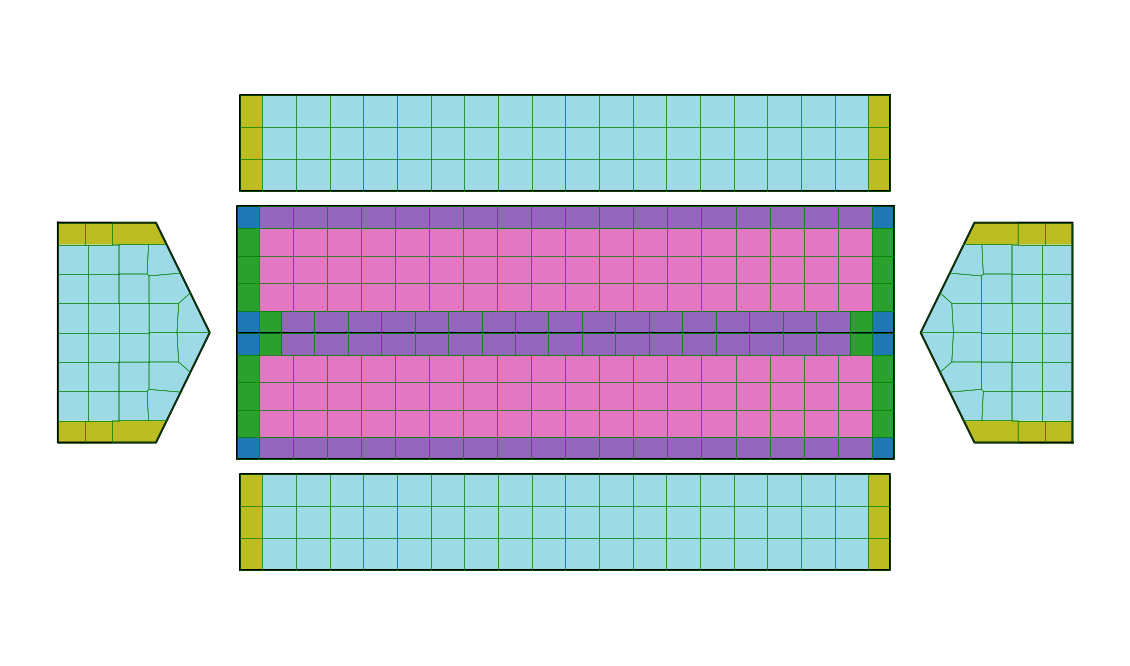

In [42]:
fig = plt.figure(figsize=[20,12])
ax = fig.add_subplot()

bldg_iso.plotEdges(ax=ax,showName=False)
# bldg_iso.plotTaps(ax=ax,showTapNo=False)
bldg_iso.plotZones(ax=ax)
bldg_iso.plotPanels(ax=ax,aIdx=2)

# bldg_iso.plotTribs(ax=ax)
# bldg_iso.plotPanels(ax=ax,aIdx=2)

ax.axis('equal')
ax.axis('off')
# if saveFigs:
#     fig.savefig(figDir+"tapLayout.svg",format='svg',dpi=1200, bbox_inches='tight')



## Wind field

### Exposure conditions

Tunnel configurations for the considered exposures

### Read data

In [13]:
sFreq = 1600
dt = 1/sFreq

pDir =profileDir+"tngE2/"
Z = np.squeeze(pd.read_csv(pDir+"Z.csv"))
U_TH = np.load(pDir+"UofT.npy")
V_TH = np.load(pDir+"VofT.npy")
W_TH = np.load(pDir+"WofT.npy")
vel_OP = wind.profile(name="BLWT - OP", Z=Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=32,keepTH=True)

pDir =profileDir+"tngE3/"
Z = np.squeeze(pd.read_csv(pDir+"Z.csv"))
U_TH = np.load(pDir+"UofT.npy")
V_TH = np.load(pDir+"VofT.npy")
W_TH = np.load(pDir+"WofT.npy")
vel_SU = wind.profile(name="BLWT - SU", Z=Z,UofT=U_TH.transpose(),VofT=V_TH.transpose(),WofT=W_TH.transpose(),H=H,dt=dt,nSpectAvg=32,keepTH=True)

del(U_TH, V_TH, W_TH)

In [14]:
if exp == 'E2':
    z0 = 0.02
    vel_WT = vel_OP
elif exp == 'E3':
    z0 = 0.2
    vel_WT = vel_SU

es85 = wind.ESDU85(z0=0.02, Zref=H/lScl, Uref=25.0)
es74 = wind.ESDU74(z0=0.02, Zref=H/lScl, Uref=25.0)
vel_E2_ESDU = es85.toProfileObj()
vel_E2_ESDU.SpectH = es74.toProfileObj().SpectH
vel_E2_ESDU.name = r'ESDU ($z_0=0.02m$)'
vel_E2_ESDU.SpectH.name = r'ESDU ($z_0=0.02m$)'

es85 = wind.ESDU85(z0=0.2, Zref=H/lScl, Uref=25.0)
es74 = wind.ESDU74(z0=0.2, Zref=H/lScl, Uref=25.0)
vel_E3_ESDU = es85.toProfileObj()
vel_E3_ESDU.SpectH = es74.toProfileObj().SpectH
vel_E3_ESDU.name = r'ESDU ($z_0=0.2m$)'
vel_E3_ESDU.SpectH.name = r'ESDU ($z_0=0.2m$)'

vel = wind.Profiles([vel_OP, vel_E2_ESDU, vel_SU, vel_E3_ESDU])

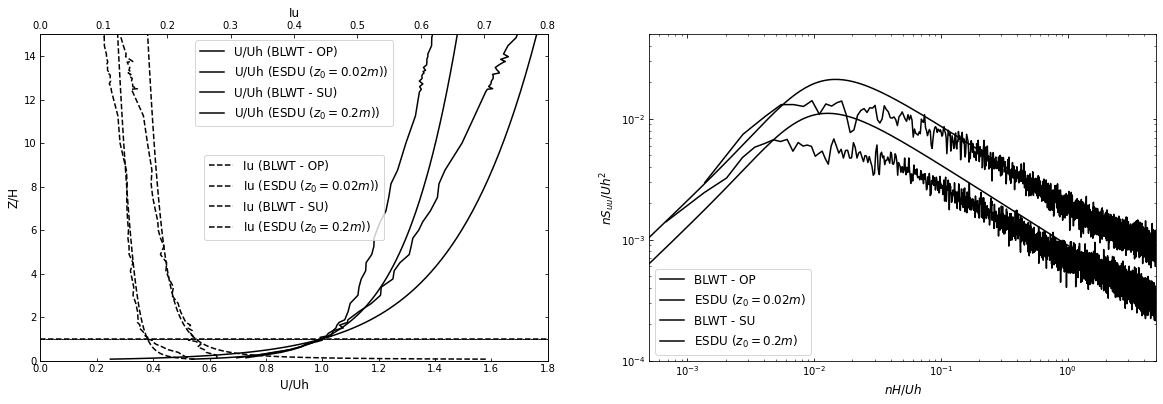

In [15]:
# print(np.shape(vel_OP.UofT))

# vStat = wind.get_velTH_stats(UofT=vel_OP.UofT, VofT=vel_OP.VofT, WofT=vel_OP.WofT,
#                              dt=vel_OP.dt, fields=wind.VALID_VELOCITY_STAT_FIELDS)

# kwargs = {}

# for k in vStat:
#     # print(np.shape(vStat[k]))
#     plt.figure()
#     plt.plot(vStat[k], vel_OP.Z, **kwargs)
#     plt.title(k)

# vel_OP.plotProfile_any('uw')
# vel_OP.plotProfile_basic1(figsize=[7,5], ylim=[0,5], U_lim=[0, 1.6], Iu_lim=[0, 0.8], )
# fig = vel_OP.plotProfile_basic2(ylim=[0,5], uw_lim=[0, 0.01], kwargs={'color': 'k', 'linestyle': '-'},)

# print(vel_OP.SpectH)
# fig = plt.figure(figsize=[6,6])
# ax = fig.add_subplot()
# vel_OP.SpectH.plotSpectra(fig=fig, axs=[ax,ax,ax], normalize=True, xLabel=r'$nH/Uh$', yLabel=r'$\frac{1}{n}\frac{dP}{d\ln(nH/Uh)}$')

vel.plot(
            figsize=[20,6], landscape=True,
            # figsize=[10,15], landscape=False,
            kwargs_profile={
                            'yLimits': [0,15], 
                            'xLimits_U': [0, 1.8], 
                            'xLimits_Iu': [0, 0.8],
                            # 'kwargs_U': {'color': 'k', 'linestyle': '-'},
                            # 'kwargs_Iu': {'color': 'k', 'linestyle': '--'},
                            # 'kwargs_legend_U': {'fontsize': 12, 'loc': 'upper center'},
                            # 'kwargs_ax': {'gridMajor':True, 'gridMinor':True}
                            }, 
            kwargs_spect={
                            'yLimits':[1e-4, 5e-2],
                            'xLimits': [5e-4, 5],
                            # 'kwargs_legend': {'fontsize': 12, 'loc': 'lower left'},
                            'kwargs_ax': {'gridMajor':True, 'gridMinor':True}
                            },)

### Plot wind field

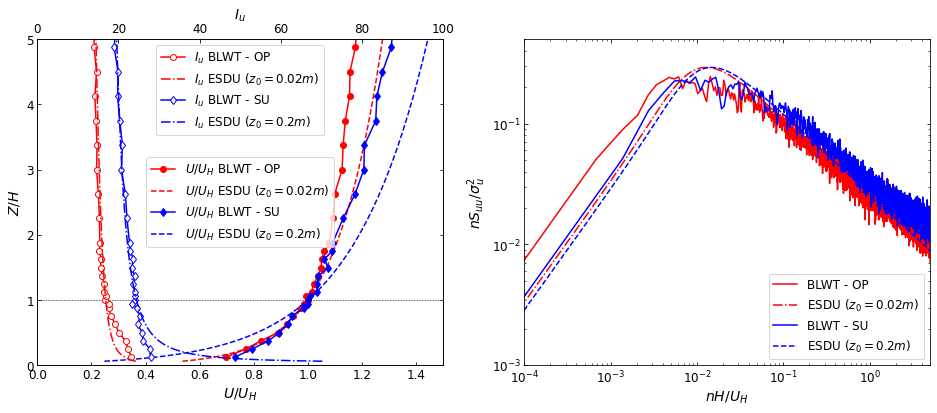

In [16]:
fig = vel.plot__(fig=plt.figure(figsize=[16,6]),zLim=[0,5], IuLim=[0,100], Ulim=[0,1.5],
        col=['r','r','b','b','g','g'],
        marker_Iu=   ['o','None','d','None','v','None'],
        linestyle_Iu=['-','-.',  '-','-.',  '-','--'],
        marker_U=    ['o','None','d','None','v','None'],
        linestyle_U= ['-','--',  '-','--',  '-','--'],
        marker_Spect=   ['None','None','None','None','None','None'],
        linestyle_Spect=['-','-.',  '-','--',  '-','--'],
        alpha_Spect=[0.5, 1.0, 0.5, 1.0],
        IuLgndLoc='upper center', UlgndLoc='center',
        fontSz_axLbl=14, fontSz_axNum=12, fontSz_lgnd=12,
        freqLim=[1e-4, 5], rSuuLim=[1e-3,0.5]
        )
# if saveFigs:
#     fig.savefig(figDir+"windField.svg",format='svg',dpi=1200, bbox_inches='tight')

## Surface pressure, $C_p$

### Read data

In [17]:
analogChannels_idxs={
                'main_pitot': 0,
                'xref_pitot': 2,
            }
pressureExtraChannels_tapNos={
                'main_pitot_zero': 2909,
                'main_pitot_queue': 2910,
                '20inch_pitot_zero': 2907,
                '20inch_pitot_queue': 2908,
                'Uh_pitot_zero': 2905,
                'Uh_pitot_queue': 2906,
            }

peakSpecs = wind.DEFAULT_PEAK_SPECS
# peakSpecs = {
#                 'method':'minmax',
#             }
peakSpecs['Num_seg'] = 10
peakSpecs['Duration'] = 10
peakSpecs['prob_non_excd'] = 0.8

In [18]:
cp_raw = wt.BLWTL_HFPI(
    caseDir=casedir,
    userNotes=None,
    Z_MainPitot=1.48,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=200.0,
    # lowpassFreq=222.223,
    Ntaps=440,
)
winsound.Beep(1000, 1000)
print((cp_raw.CpTH.shape))
print(cp_raw.sampleRate)

(40, 440, 36000)


In [19]:
cp = wind.bldgCp(
                bldgName=f"nrcNB{caseID}{caseID}",
                faces=faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                caseName=caseToRun,
                refProfile=vel_WT,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                samplingFreq=cp_raw.sampleRate,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH,
                badTaps=None,
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                keepTH=False,
                )
winsound.Beep(1000, 1000)

In [20]:
print(np.mean(cp.Uref))
print(cp.lScl)

12.148864314055455
0.01


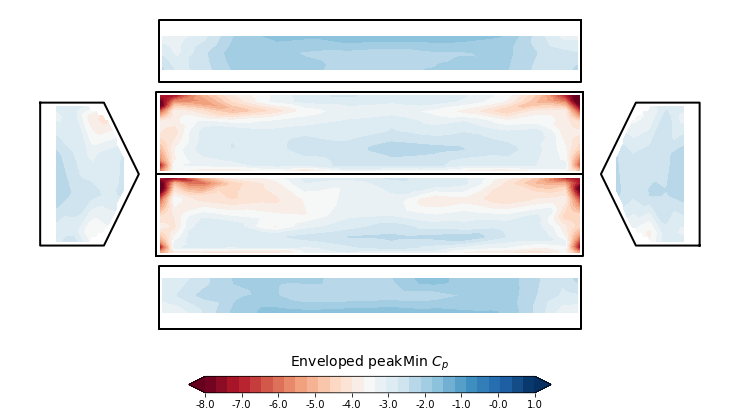

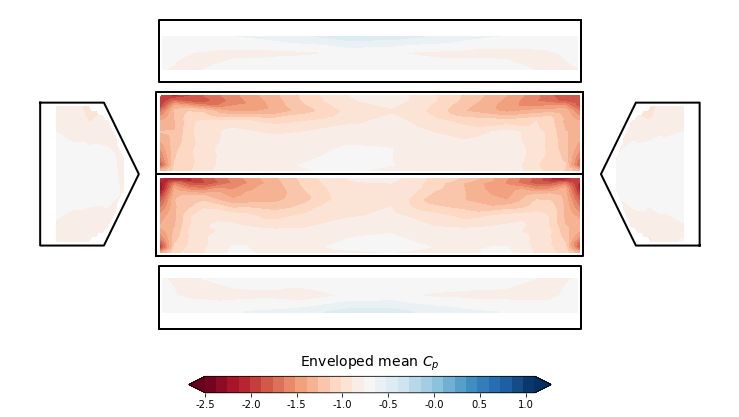

In [21]:
from matplotlib.ticker import FuncFormatter

# fld, fldrange, ticks = 'mean', [-2.5, 1.1], np.linspace(-2.5,1.0,8)
fld, fldrange, ticks = 'peakMin', [-8., 1.], np.linspace(-8,1.0,10)

fig = plt.figure(figsize=[13,8])
ax = plt.subplot()
im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$")
cp.plotEdges(ax=ax, showName=False)
ax.axis('equal')
ax.axis('off')
# cbar = fig.colorbar(im[0], ax=ax, orientation='vertical',aspect=20,shrink=0.5,pad=0.0)
# cbar.set_label(fld+r" $C_p$", fontsize=14, rotation=270, labelpad=20)
# cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}'))
cbar = fig.colorbar(im[0], ax=ax, orientation='horizontal',aspect=20,shrink=0.5,pad=0.08)
cbar.set_ticks(ticks)
cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=14, rotation=0, labelpad=10)
cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
cbar.ax.xaxis.set_label_position('top')
# cbar.ax.tick_params(labeltop=True, top=True)
# cbar.ax.set_ylabel('Label', rotation=270, labelpad=15)
# cbar.ax.set_title('Title', rotation=270, pad=20)
if saveFigs:
    fig.savefig(figDir+f"nrcNB{caseID}{exp}_Cp_{fld}.svg",format='svg',dpi=1200, bbox_inches='tight')



fld, fldrange, ticks = 'mean', [-2.5, 1.1], np.linspace(-2.5,1.0,8)

fig = plt.figure(figsize=[13,8])
ax = plt.subplot()
im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$")
cp.plotEdges(ax=ax, showName=False)
ax.axis('equal')
ax.axis('off')
cbar = fig.colorbar(im[0], ax=ax, orientation='horizontal',aspect=20,shrink=0.5,pad=0.08)
cbar.set_ticks(ticks)
cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=14, rotation=0, labelpad=10)
cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
cbar.ax.xaxis.set_label_position('top')
if saveFigs:
    fig.savefig(figDir+f"nrcNB{caseID}{exp}_Cp_{fld}.svg",format='svg',dpi=1200, bbox_inches='tight')

#### Wind tunnel data

### $C_p$ Plots

#### Local pressure

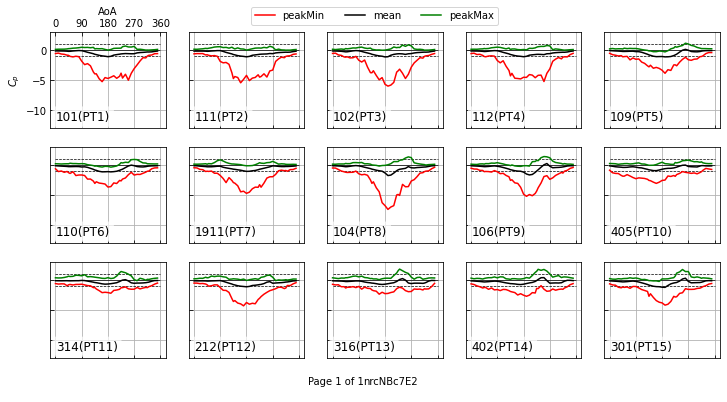

In [ ]:
# figs = cp.plotTapCpStatsPerAoA(xticks=np.linspace(0,360,5),pageNo_xy=(0.5,0.06),nCols=7, figsize=[20,20],mrkrs=['None','None','None'], fldRange=[-13,3])#,fields=['mean','std'])

tapsToPlot=[101, 111, 102, 112, 109, 110, 1911, 104, 106, 405, 314, 212, 316, 402, 301]
figs = cp.plotTapCpStatsPerAoA(tapsToPlot=tapsToPlot,
                xticks=np.linspace(0,360,5),pageNo_xy=(0.5,0.04),nCols=5, nRows=3, figsize=[12,6],mrkrs=['None','None','None'], fldRange=[-13,3],
                legend_bbox_to_anchor=(0.5, 0.95))#,fields=['mean','std'])

# if saveFigs:
#     for p,fig in enumerate(figs):
#         fig.savefig(figDir+f"nrcNB{caseID}{exp}_CpStatsPerAoA_pg_{p+1}.svg",format='svg',dpi=1200, bbox_inches='tight')


In [31]:
# nrow, ncol = 8, 5

# fld = 'mean'
# fldRange=[-1.6,0.8]

# fig, axs = plt.subplots(nrow, ncol)
# fig.set_figheight(4*nrow)
# fig.set_figwidth(6*ncol)
# fig.subplots_adjust(wspace=0.0, hspace=0.0)

# for d,D in enumerate(cp.AoA):
#     ax = axs[d//ncol, d%ncol]
#     cp.plotTapCpStatContour(fieldName=fld,dxnIdx=d,ax=ax,fldRange=fldRange)
#     cp.plotEdges(ax=ax,showName=False)
#     # nrcNBc2E2.plotTaps(ax=ax,dotSz=1)
#     ax.axis('off')
#     ax.axis('equal')
#     # ax.set_title(r'$\theta='+str(np.round(D,0))+r'^\circ$',fontsize=16)

# if saveFigs:
#     fig.savefig(figDir+"Cp_"+fld+".svg",format='svg',dpi=600, bbox_inches='tight')
print(np.mean(cp.Uref))
print(cp.samplingFreq)

12.148864314055455
[200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.]


#### Area averaged load

In [ ]:
NBCC_A_min = [
            [0.1, 1, 10, 100], # c
            [0.1, 2.2, 10, 100], # s
            [0.1, 1, 10, 100], # r
            ]
NBCC_CpCg_min = np.array([
            [-5, -5, -4, -4],
            [-3.6, -3.6, -2.6, -2.6],
            [-2.45, -2.45, -2, -2]
            ],dtype=float)
NBCC_A_max = [0.1, 1, 10, 100]
NBCC_CpCg_max = np.array([0.75, 0.75, 0.5, 0.5],dtype=float)

ft2m_sq = 0.3048**2

ASCE_A_min = np.array([
            [0.1, 10, 500, 2000], # 3
            [0.1, 10, 500, 2000], # 2
            [0.1, 10, 500, 2000], # 1
            [0.1, 100, 500, 2000], # 1'
            ],dtype=float)*ft2m_sq
ASCE_GCp_min = np.array([
            [-3.2, -3.2, -1.4, -1.4], # 3
            [-2.3, -2.3, -1.4, -1.4], # 2
            [-1.7, -1.7, -1.0, -1.0], # 1
            [-0.9, -0.9, -0.4, -0.4], # 1'
            ],dtype=float)
ASCE_A_max = np.array([0.1, 100, 500, 2000],dtype=float)*ft2m_sq
ASCE_GCp_max = np.array([0.3, 0.3, 0.2, 0.2],dtype=float)


In [214]:
NBCC_min = cp.zoneDict.copy()
NBCC_max = cp.zoneDict.copy()
# invDxnFactor = 1/0.85

print(f"{NBCC_min[0][0]} {NBCC_min[0][1]}")
NBCC_min[0][2] = {}     # Zone c
NBCC_min[0][2]['area'] = [0.1,1,10,100]
NBCC_min[0][2]['value'] = [-5,-5,-4,-4]

NBCC_min[1][2] = {}     # Zone sp
NBCC_min[1][2]['area'] = []
NBCC_min[1][2]['value'] = []

NBCC_min[2][2] = {}     # Zone s
NBCC_min[2][2]['area'] = [0.1,2.2,10,100]
NBCC_min[2][2]['value'] = [-3.6,-3.6,-2.65,-2.65]

NBCC_min[3][2] = {}     # Zone r
NBCC_min[3][2]['area'] = [0.1,0.85,10,100]
NBCC_min[3][2]['value'] = [-2.5,-2.5,-2,-2]

NBCC_min[4][2] = {}     # Zone e
NBCC_min[4][2]['area'] = [0.1,1,50,200]
NBCC_min[4][2]['value'] = [-2.1,-2.1,-1.5,-1.5]

NBCC_min[5][2] = {}     # Zone w
NBCC_min[5][2]['area'] = [0.1,1,50,200]
NBCC_min[5][2]['value'] = [-1.8,-1.8,-1.5,-1.5]



NBCC_max[0][2] = {}     # Zone c
NBCC_max[0][2]['area'] = [0.1,1,8.5,100]
NBCC_max[0][2]['value'] = [0.8,0.8,0.5,0.5]

NBCC_max[1][2] = NBCC_min[1][2]     # Zone sp

NBCC_max[2][2] = NBCC_max[0][2]    # Zone s
NBCC_max[3][2] = NBCC_max[0][2]    # Zone r

NBCC_max[4][2] = {}     # Zone e
NBCC_max[4][2]['area'] = [0.1,1,50,200]
NBCC_max[4][2]['value'] = [1.75,1.75,1.3,1.3]

NBCC_max[5][2] = NBCC_max[4][2]     # Zone w

print(NBCC_max)

NBCC 2020 Zone c
{0: ['NBCC 2020', 'Zone c', {'area': [0.1, 1, 8.5, 100], 'value': [0.8, 0.8, 0.5, 0.5]}], 1: ['NBCC 2020', 'Zone sp', {'area': [], 'value': []}], 2: ['NBCC 2020', 'Zone s', {'area': [0.1, 1, 8.5, 100], 'value': [0.8, 0.8, 0.5, 0.5]}], 3: ['NBCC 2020', 'Zone r', {'area': [0.1, 1, 8.5, 100], 'value': [0.8, 0.8, 0.5, 0.5]}], 4: ['NBCC 2020', 'Zone e', {'area': [0.1, 1, 50, 200], 'value': [1.75, 1.75, 1.3, 1.3]}], 5: ['NBCC 2020', 'Zone w', {'area': [0.1, 1, 50, 200], 'value': [1.75, 1.75, 1.3, 1.3]}]}


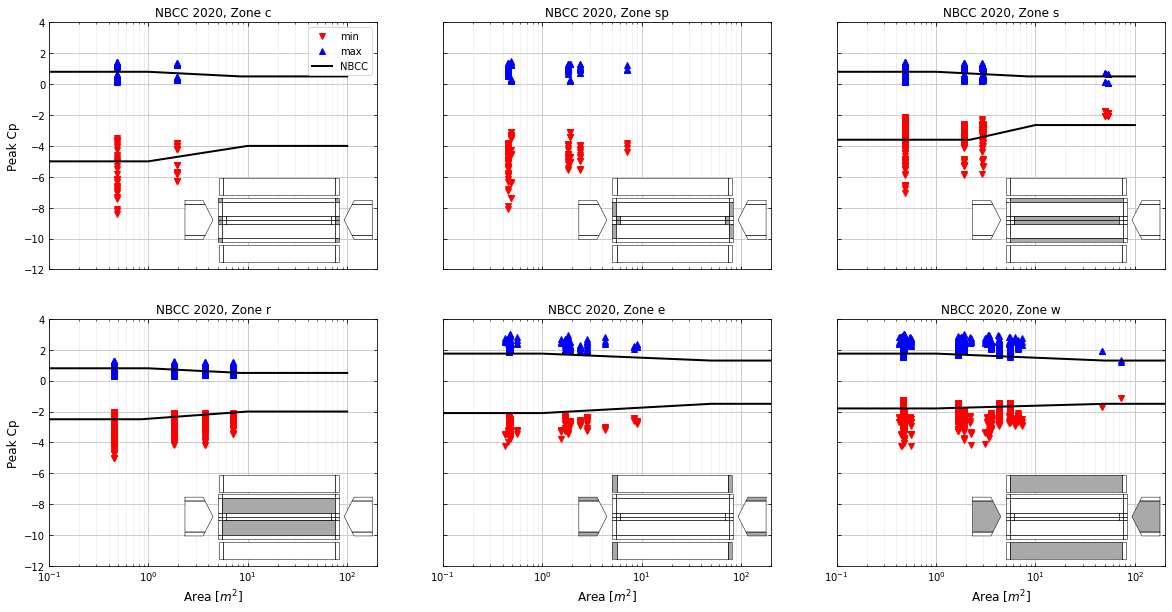

In [217]:
areaFctr_FS = (1e-3/cp.lScl)**2
cp.plotAreaAveragedStat(figSize=[20,10], plotExtremesPerNominalArea=False, xLimits=[1e-1, 200], yLimits=[-12, 4], areaFactor=areaFctr_FS, 
                        plotZoneGeom=True, insetBounds=[0.4,0,0.6,0.4], nCols=3, invertYAxis=True,
                        overlayThis_min=NBCC_min, overlayThis_max=NBCC_max, overlayLabel_max='NBCC', ) 

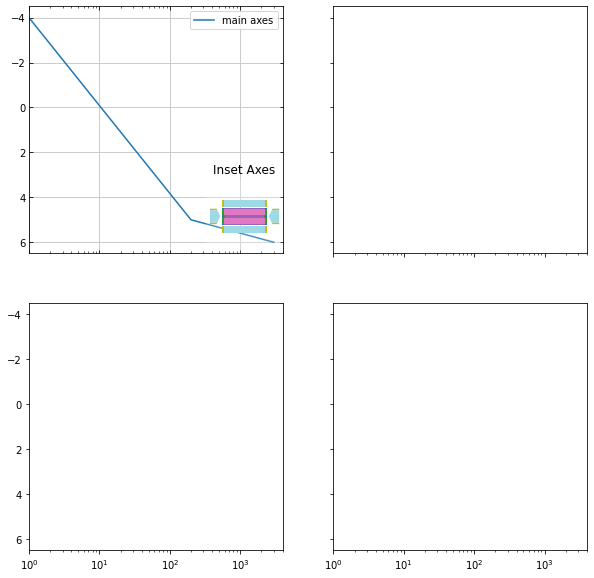

In [191]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=[10,10], sharex=True, sharey=True)
ax = axs[0,0]
# create inset axes
axin = ax.inset_axes([0.7, 0.0, 0.3, 0.3])

# set the location of the inset axes
axin.set_position([0, 0, 1, 1], which='both')
axin.patch.set_alpha(0.5)
axin.set_xticklabels('')
axin.set_yticklabels('')

# add some data to the main axes
ax.semilogx([1, 200, 3000], [-4, 5, 6], label='main axes')
ax.set_xlim(1, 4000)

ax.invert_yaxis()

# add some data to the inset axes
# axin.plot([2, 3, 4], [1, 2, 3])
cp.plotZones(ax=axin)

# set the location of the inset axes using a string value
axin.set_title('Inset Axes')
axin.patch.set_facecolor('w')
axin.patch.set_alpha(0.2)
# ax.indicate_inset_zoom(axin, alpha=0.5, edgecolor='gray', linewidth=2, facecolor='gray', fill=False)

axin.locator_params(nbins=5, axis='x')
# axin.set_xlim(2, 4)
# axin.set_ylim(1, 3)
# axin.grid(True)
axin.axis('equal')
axin.tick_params(axis='both', which='major', length=0)
for spine in axin.spines.values():
    spine.set_visible(False)
ax.legend()
# wind.formatAxis(axin)
wind.formatAxis(ax)

# show the plot
plt.show()
